# **Text Classification using BERT**


In [ ]:
!pip install transformers
import os
import gdown
import torch
import numpy as np
import seaborn as sns
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from sklearn import metrics

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

%matplotlib inline

# gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
# gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print ("Train and Test Files Loaded as train.csv and test.csv")

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
NONE = 4 * [None]
RND_SEED=2020

def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ["Negative","Neutral","Positive"]
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure(figsize=(7,6))
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

--2025-07-06 16:49:36--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29264 (29K) [application/vnd.ms-excel]
Saving to: ‘finance_test.csv’

finance_test.csv    100%[===================>]  28.58K  --.-KB/s    in 0s      

2025-07-06 16:49:36 (99.9 MB/s) - ‘finance_test.csv’ saved [29264/29264]

--2025-07-06 16:49:36--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com

In [ ]:
df_train = get_finance_train()
df_test = get_finance_test()

In [ ]:
sentences = df_train["Sentence"].values
labels = df_train["Label"].values

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.tokenize(sentences[0])

['auto',
 '##tan',
 '##k',
 'group',
 'is',
 'part',
 'of',
 'as',
 '##po',
 "'",
 's',
 'systems',
 'division',
 '.']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0]))

[8285,
 5794,
 2243,
 2177,
 2003,
 2112,
 1997,
 2004,
 6873,
 1005,
 1055,
 3001,
 2407,
 1012]

In [ ]:
sentences_with_special_tokens = []
for sentence in sentences:
  sentences_with_special_tokens.append('[CLS]' + sentence + '[SEP]')
print(sentences_with_special_tokens[0])

[CLS]Autotank Group is part of Aspo 's Systems Division .[SEP]


In [ ]:
tokenized_texts = []
for sentence in sentences_with_special_tokens:
  tokenized_texts.append(tokenizer.tokenize(sentence))

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]

In [ ]:
input_ids = pad_sequences(input_ids,
                          maxlen=128,
                          dtype="long",
                          truncating="post",
                          padding="post")
print(input_ids)

[[ 101 8285 5794 ...    0    0    0]
 [ 101 1996 3206 ...    0    0    0]
 [ 101 9680 7911 ...    0    0    0]
 ...
 [ 101 5356 4834 ...    0    0    0]
 [ 101 1999 1996 ...    0    0    0]
 [ 101 2747 1996 ...    0    0    0]]


In [ ]:
attention_masks=[]
for input_id in input_ids:
  mask = [float(i>0) for i in input_id]
  attention_masks.append(mask)
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels, test_size=0.15, random_state=RND_SEED)

In [ ]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.15, random_state=RND_SEED)

In [ ]:
train_inputs = torch.tensor(np.array(X_train));
validation_inputs = torch.tensor(np.array(X_val));
train_masks = torch.tensor(np.array(train_masks));
validation_masks = torch.tensor(np.array(validation_masks));
train_labels = torch.tensor(np.array(y_train));
validation_labels = torch.tensor(np.array(y_val));

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels);
train_sampler = RandomSampler(train_data); # Samples data randomly for training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size);
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels);
validation_sampler = SequentialSampler(validation_data); # Samples data sequentially
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size);

In [ ]:
#Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT small model, with an uncased vocab.
    num_labels = 3,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
);

# Given that this a huge neural network, we need to explicity specify
# in pytorch to run this model on the GPU.
model.cuda();

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'Tesla T4'

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
epochs = 4

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# We'll store training and validation loss,
# validation accuracy, and timings.
training_loss = []
validation_loss = []
training_stats = []
for epoch_i in range(0, epochs):
    # Training
    print('Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training the model')
    # Reset the total loss for  epoch.
    total_train_loss = 0
    # Put the model into training mode.
    model.train()
    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 20 == 0 and not step == 0:
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        # STEP 1 & 2: Unpack this training batch from our dataloader.
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # STEP 3
        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # STEP 4
        # Perform a forward pass (evaluate the model on this training batch).
        # It returns the loss (because we provided labels) and
        # the "logits"--the model outputs prior to activation.
        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # STEP 5
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # STEP 6
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # Validation
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("Evaluating on Validation Set")
    # Put the model in evaluation mode
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        #Step 1 and Step 2
        # Unpack this validation batch from our dataloader.

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)



    print("Validation Loss: {0:.2f}".format(avg_val_loss))


    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)
    # Record all statistics from this epoch.

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy

        }
    )

print("Training complete!")

Epoch 1 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.61
Evaluating on Validation Set
Validation Accuracy: 0.81
Validation Loss: 0.38
Epoch 2 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.25
Evaluating on Validation Set
Validation Accuracy: 0.96
Validation Loss: 0.15
Epoch 3 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.08
Evaluating on Validation Set
Validation Accuracy: 0.95
Validation Loss: 0.15
Epoch 4 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.05
Evaluating on Validation Set
Validation Accuracy: 0.97
Validation Loss: 0.13
Training complete!


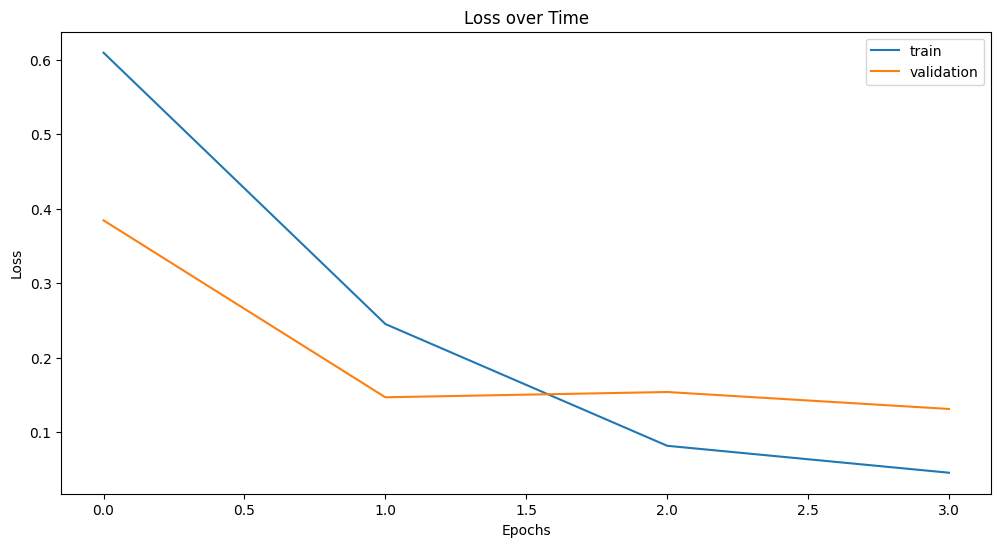

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

### YOUR CODE HERE
plt.plot(training_loss, label='train')
plt.plot(validation_loss, label='validation')
### END CODE

plt.legend()
plt.show()

In [ ]:
test_sentences = df_test['Sentence'].values
test_labels = df_test['Label'].values

In [ ]:
test_input_ids, test_attention_masks = [], []

# Add Special Tokens
test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]

# Tokenize sentences
tokenized_test_sentences = [tokenizer.tokenize(sent) for sent in test_sentences]

# Encode Tokens to Word IDs
test_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_sentences]

# Pad the inputs
test_input_ids = pad_sequences(test_input_ids,
                               maxlen=128,
                               dtype="long",
                               truncating="post",
                               padding="post")

# Create Attention Masks
for sequence in test_input_ids:
  mask = [float(i>0) for i in sequence]
  test_attention_masks.append(mask)

In [ ]:
batch_size = 32
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Predicting labels for 227 test sentences...
Test Accuracy: 97.36%
Plotting the Confusion Matrix


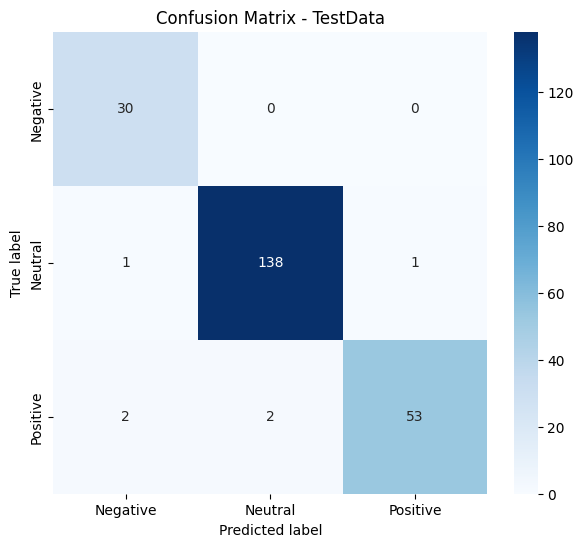

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

# Final tracking variables
y_logits, y_true, y_preds = [], [], []

# Gather logit predictions
for chunk in predictions:
  for logits in chunk:
    y_logits.append(logits)

# Gather true labels
for chunk in true_labels:
  for label in chunk:
    y_true.append(label)

# Gather real predictions
for logits in y_logits:
  y_preds.append(np.argmax(logits))

print ('Test Accuracy: {:.2%}'.format(metrics.accuracy_score(y_preds,y_true)))
plot_confusion_matrix(y_true,y_preds)